VERSION 3: Embedding

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
min_transactions = 200

N = 25 #number of pre-transactions used for predict
length = 20
num_of_items = 57 
NUL_ID = num_of_items - 1
time_slot = 24*60*60*1000 #1 day
time_slot

86400000

In [ ]:
RAWDATA_PATH = '/content/gdrive/MyDrive/NCKH/Multi-LayerPerceptron/rawdata.csv'
HASH_FILE_PATH = '/content/gdrive/MyDrive/NCKH/Multi-LayerPerceptron/hash_table.csv'
NEW_DATA_PATH = '/content/gdrive/MyDrive/NCKH/Multi-LayerPerceptron/UserMoreThan200Trans.csv'
WEIGHTS_PATH = '/content/gdrive/MyDrive/NCKH/Multi-LayerPerceptron/mlp_v3.hdf5'

In [ ]:
#load proceessed data
# df = pd.read_csv(NEW_DATA_PATH)
df_hash = pd.read_csv(HASH_FILE_PATH)

temp = zip(df_hash.itemID,df_hash.hash_value)
hash_itemID = dict(temp)

temp = zip(df_hash.hash_value,df_hash.itemID)
reverse_hash_itemID = dict(temp)

# Prepare data

Note: Ignore "Load data", "Ignore user" if you use processed data

## Load data, convert to dataframe

In [ ]:
df = pd.read_csv(RAWDATA_PATH)
df.head()

,timestamp,userID,itemID
0,1604163797349,eed56d467112a57bbad058399b9c146410221,122
1,1604164215912,488f41e8995c2d6f5069eb46f723ee8710221,113
2,1604164499407,82e3bc40fbaf250d546b4e4de6bdb3aa10221,101
3,1604164521426,82e3bc40fbaf250d546b4e4de6bdb3aa10221,106
4,1604164654112,488f41e8995c2d6f5069eb46f723ee8710221,26


In [ ]:
hash_itemID = {}
idx = 0
for itemID in set(df.itemID):
  hash_itemID[itemID] = idx
  idx += 1

In [ ]:
with open(HASH_FILE_PATH,'w') as f:
  f.write('itemID,hash_value\n')
  for item in hash_itemID:
    f.write(f'{item},{hash_itemID[item]}\n')

In [ ]:
reverse_hash_itemID = {hash_itemID[i]:i for i in hash_itemID}

## Ignore user has less transactions

In [ ]:
from google.colab import output

In [ ]:
len(df), len(list(set(df.userID)))

(84902, 306)

Bước tiếp theo lọc ra các user có ít transactions, cụ thể là < 200, tại sao và để làm gì???

In [ ]:
lst_user = list(set(df.userID))

new_df = pd.DataFrame(columns=df.columns)
idx = 0
for userID in lst_user:
  print(f'{idx}/{len(lst_user)}' + ' : ', end=" ")
  idx += 1
  subdf = df[df.userID == userID]
  print(len(subdf))
  if len(subdf) > min_transactions: new_df = new_df.append(subdf, ignore_index=True)
  output.clear()

lst_user = list(set(new_df.userID)) #re-assign lst_user

In [ ]:
len(new_df),len(list(set(new_df.userID)))

(84902, 306)

In [ ]:
new_df

,timestamp,userID,itemID
0,1604210094225,0f2333496cf8f2c3b024a37411cc040d10221,101
1,1604237015743,0f2333496cf8f2c3b024a37411cc040d10221,123
2,1604308960896,0f2333496cf8f2c3b024a37411cc040d10221,123
3,1604316130167,0f2333496cf8f2c3b024a37411cc040d10221,123
4,1604316720663,0f2333496cf8f2c3b024a37411cc040d10221,123
...,...,...,...
84897,1619492031694,490b8b6f28329274856b097082a7520b10221,21
84898,1619536853411,490b8b6f28329274856b097082a7520b10221,151
84899,1619627810118,490b8b6f28329274856b097082a7520b10221,21
84900,1619710912484,490b8b6f28329274856b097082a7520b10221,21


In [ ]:
df = new_df.sort_values(by='timestamp')
df = df.reset_index(drop=True)
df

,timestamp,userID,itemID
0,1604163797349,eed56d467112a57bbad058399b9c146410221,122
1,1604164215912,488f41e8995c2d6f5069eb46f723ee8710221,113
2,1604164499407,82e3bc40fbaf250d546b4e4de6bdb3aa10221,101
3,1604164521426,82e3bc40fbaf250d546b4e4de6bdb3aa10221,106
4,1604164654112,488f41e8995c2d6f5069eb46f723ee8710221,26
...,...,...,...
84897,1619801123715,3fe32324b910330aa272d747e1e2491610221,101
84898,1619801333120,36b7fa8458ab24566e7f2a5d3160b9ec10221,101
84899,1619801540282,e4649e124f01e623dd240562a11a989810221,61
84900,1619801886094,48d73dd062c7e7417d82fd5c5da4517f10221,21


In [ ]:
df.to_csv(NEW_DATA_PATH,index=False)

In [ ]:
# time_slot = -1
# for userID in lst_user:
#   subdf = df[df.userID == userID]
#   times = subdf.timestamp.tolist()
#   new_value = min([times[x]-times[x-1] for x in range(1,len(times))],default=-1)
#   if new_value < time_slot or time_slot == -1:
#     time_slot = new_value

# time_slot

## Generate time series data

In [ ]:
import math

start_time = min(df.timestamp)
end_time = max(df.timestamp)
num_of_slots = math.ceil((end_time-start_time)/time_slot)
start_time,end_time,num_of_slots

(1604163797349, 1619801952751, 181)

### example

In [ ]:
userID = 'eed56d467112a57bbad058399b9c146410221'
subdf = df[df.userID == userID]
subdf

,timestamp,userID,itemID
0,1604163797349,eed56d467112a57bbad058399b9c146410221,122
40,1604180842140,eed56d467112a57bbad058399b9c146410221,101
689,1604319498998,eed56d467112a57bbad058399b9c146410221,5
716,1604324486866,eed56d467112a57bbad058399b9c146410221,122
852,1604361560049,eed56d467112a57bbad058399b9c146410221,122
...,...,...,...
83635,1619586629446,eed56d467112a57bbad058399b9c146410221,26
83636,1619586758395,eed56d467112a57bbad058399b9c146410221,106
83777,1619605764963,eed56d467112a57bbad058399b9c146410221,122
84582,1619747121675,eed56d467112a57bbad058399b9c146410221,63


In [ ]:
series = np.zeros((num_of_slots,num_of_items))
count = [0]*num_of_slots
lst_time = subdf.timestamp.tolist()
lst_itemID = subdf.itemID.tolist()
for time,itemID in zip(lst_time,lst_itemID):
  idx = (time-start_time) // time_slot
  series[idx][hash_itemID[itemID]] = 1
  count[idx] += 1

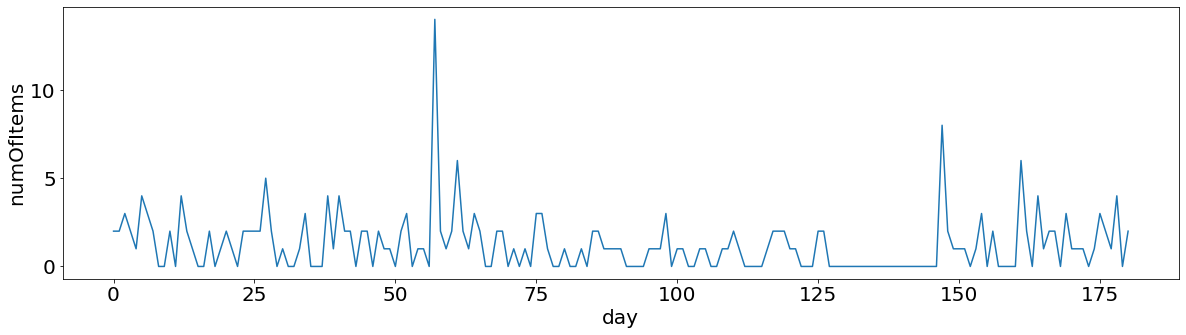

In [ ]:
plt.figure(figsize=(20,5))
plt.rc('font', size=20) 
plt.plot(range(len(count)),count)
plt.xlabel('day',fontsize=20)
plt.ylabel('numOfItems',fontsize=20)
plt.show()

In [ ]:
history = list(map(lambda x: hash_itemID[x],subdf.itemID.tolist()))
print(*history,sep=' ')

55 41 4 55 55 55 55 1 21 21 20 7 0 31 6 21 29 29 30 15 31 20 30 29 30 6 21 21 30 30 20 6 21 3 41 45 41 3 47 41 20 41 6 41 2 1 21 21 0 44 20 6 7 21 29 29 30 29 30 29 30 30 20 6 0 1 2 30 21 3 30 20 4 6 5 30 55 30 54 55 22 6 19 23 41 45 55 30 55 55 30 55 55 56 54 30 41 55 41 41 55 55 41 17 18 9 21 9 6 55 55 55 55 7 30 31 29 6 29 30 1 30 30 30 6 9 17 30 29 6 41 45 41 44 41 41 41 6 7 30 6 29 29 29 16 30 6 0 30 30 1 2 6 55 41 45 41 6 41 55 41 41 7 6 29 29 41 45 6 0 1 2 29 3 41 30 41 41 41 4 6 7 5 31 29 6 29 30 44 30 0 19 23 30 30 30 22 31 30 30 6 30 55 55 55 55 22 55 41 41 6 1 41 0 41 41 22 45 55 30 30


In [ ]:
import more_itertools as mit
X_idx = np.array(list(mit.windowed(history, n=N, step=1)))[:-1]
y = history[N:]

In [ ]:
X = []
for x in X_idx:
  new_record = [0]*num_of_items
  new_record[x[0]] = 1
  new_record[x[1]] = 1
  new_record[x[2]] = 1
  X.append(new_record)
X = np.array(X)

### generate

In [ ]:
lst_user = list(set(df.userID))
len(lst_user)

306

In [ ]:
import more_itertools as mit
from google.colab import output
from functools import reduce
X_item2vec = []
X = []
y = []

is_exists = np.zeros(num_of_items,)

def onehot(x):
  #x: int
  lst = [0]*num_of_items
  lst[x] = 1
  return lst

def removeNul(x):
  #(1,2,-1,3,-1,2) -> (1,2,3,2)
  res = []
  return [str(i) for i in x if (i != -1)]

def flatten(x):
  #[[1],[2,1,3],[2]] -> [1,2,1,3,2]
  return [str(i) for c in x for i in c]

distance_avg = 0;

for userID in lst_user:
  subdf = df[df.userID == userID]

  # train_data for Item2Vec
  
  idx = ((subdf.timestamp - start_time) // time_slot).to_numpy()[:-1]
  count_stop_buy = (len(idx) - 1)
  # print (count_stop_buy, end=' ')
  sum = 0
  for i in range(1, len(idx)):
    sum += (idx[i] - idx[i-1])
  # print(sum)
  distance_avg += math.ceil(sum / count_stop_buy)
  itemIDs = list(map(lambda x: hash_itemID[x],subdf.itemID))[:-1]
  series = [[] for _ in range(num_of_slots)]
  
  for id,itemID in zip(idx,itemIDs):
    series[id].append(itemID)
  
  temp = list(mit.windowed(series, n=length, step=1))[:-1]  
  new_row = list(map(flatten,temp))
  X_item2vec.extend(new_row)
  

  # data for MLP
  history = list(map(lambda x: hash_itemID[x],subdf.itemID))
  new_x = list(mit.windowed(history, n=N, step=1))[:-1]
  X.extend(new_x)
  y.extend(list(map(onehot,history[N:])))
  # print(X)

print(distance_avg)
day = distance_avg / len(lst_user)

306


In [ ]:
print(type(X_item2vec))

<class 'list'>


In [ ]:
from gensim.models import Word2Vec
#CBOW model
vecs = Word2Vec(X_item2vec, min_count=2, size=20, window=5, sg=0)
vecs.wv.vocab.keys()

dict_keys(['41', '56', '46', '47', '0', '1', '2', '31', '3', '29', '4', '30', '6', '7', '5', '12', '22', '43', '45', '44', '42', '19', '23', '10', '13', '14', '39', '8', '20', '21', '33', '55', '54', '18', '15', '17', '9', '32', '38', '34', '53', '16', '28', '27', '36', '11', '48', '49', '50', '26', '37', '35', '25', '40', '24', '51', '52'])

In [ ]:
vecs['31']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 1.9003887 ,  1.9598271 ,  1.9041691 , -2.6636007 , -0.44468755,
       -0.5457681 , -2.1309638 , -0.22613177, -3.310929  ,  2.165178  ,
       -0.0434872 ,  0.6209424 ,  0.6605666 , -0.20307907,  0.213822  ,
       -2.141887  , -0.5037716 , -0.52640903,  0.7276028 , -0.633105  ],
      dtype=float32)

In [ ]:
vecs.similar_by_vector(vecs['45'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('45', 1.0),
 ('41', 0.3448970317840576),
 ('24', 0.2790309190750122),
 ('49', 0.2776511311531067),
 ('56', 0.2701655924320221),
 ('55', 0.2592143714427948),
 ('50', 0.20773044228553772),
 ('43', 0.19337305426597595),
 ('54', 0.18024995923042297),
 ('47', 0.16716670989990234)]

#### split train-test

In [ ]:
def mapping(x):
  #x = (1,2,3) -> (vect(1),vect(2),vect(3))
  return [vecs[str(i)] for i in x]

In [ ]:
tmp = mapping(X[0])
print(tmp)

[array([ 0.07174902, -1.172731  ,  1.7615573 ,  1.6256063 ,  0.9179724 ,
        1.3008643 , -1.0257443 ,  0.73911077,  1.6524668 ,  1.6030437 ,
        1.5909226 ,  0.8304199 , -2.0982924 , -0.16751073,  2.136287  ,
        0.4619756 , -1.2492485 , -2.5138557 ,  0.6201592 , -0.8904907 ],
      dtype=float32), array([-0.44549057,  0.31760994,  2.3327856 ,  0.80887264,  0.02809595,
       -3.9878173 , -4.606247  ,  0.3221665 ,  1.1916628 ,  3.6416821 ,
       -0.27402633,  0.2949079 , -0.8684626 , -3.570728  ,  3.0430863 ,
       -2.0378797 , -5.1409435 ,  0.21101584,  2.1184433 , -0.5195908 ],
      dtype=float32), array([-0.44549057,  0.31760994,  2.3327856 ,  0.80887264,  0.02809595,
       -3.9878173 , -4.606247  ,  0.3221665 ,  1.1916628 ,  3.6416821 ,
       -0.27402633,  0.2949079 , -0.8684626 , -3.570728  ,  3.0430863 ,
       -2.0378797 , -5.1409435 ,  0.21101584,  2.1184433 , -0.5195908 ],
      dtype=float32), array([-0.44549057,  0.31760994,  2.3327856 ,  0.80887264,  0.0280

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
X0 = np.array(list(map(mapping,X)))
y = np.array(y)
print(X[0:1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[(41, 56, 56, 56, 56, 46, 47, 0, 1, 2, 31, 3, 3, 3, 29, 3, 4, 2, 3, 29, 29, 30, 3, 2, 29)]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X0, y, test_size=0.3)

In [ ]:
print(X_train[0],y_train[0],sep='\n')

[[ 1.9003887   1.9598271   1.9041691  -2.6636007  -0.44468755 -0.5457681
  -2.1309638  -0.22613177 -3.310929    2.165178   -0.0434872   0.6209424
   0.6605666  -0.20307907  0.213822   -2.141887   -0.5037716  -0.52640903
   0.7276028  -0.633105  ]
 [ 0.07174902 -1.172731    1.7615573   1.6256063   0.9179724   1.3008643
  -1.0257443   0.73911077  1.6524668   1.6030437   1.5909226   0.8304199
  -2.0982924  -0.16751073  2.136287    0.4619756  -1.2492485  -2.5138557
   0.6201592  -0.8904907 ]
 [-2.2726653  -0.9695913  -1.9486839  -0.49089295 -1.0657954   1.3191905
   2.0184352  -1.3540833   0.8496445   4.4153495   0.59202695 -1.5395418
  -2.223634    2.0910263   4.7054887  -2.1815438  -2.1648798  -0.3355305
   3.6063755   0.8802609 ]
 [ 0.07174902 -1.172731    1.7615573   1.6256063   0.9179724   1.3008643
  -1.0257443   0.73911077  1.6524668   1.6030437   1.5909226   0.8304199
  -2.0982924  -0.16751073  2.136287    0.4619756  -1.2492485  -2.5138557
   0.6201592  -0.8904907 ]
 [ 0.18249175  

In [ ]:
X_train.shape

(54076, 25, 20)

# MLP

In [ ]:
import numpy as np 
import os
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

model = Sequential()

model.add(InputLayer((N,20)))
# model.add(Embedding(num_of_items,20,input_length=num_of_items))
model.add(Flatten())
model.add(Dense(128, activation= 'relu'))
model.add(Dense(num_of_items, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               64128     
_________________________________________________________________
dense_1 (Dense)              (None, 57)                7353      
Total params: 71,481
Trainable params: 71,481
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_checkpoint = ModelCheckpoint(WEIGHTS_PATH, monitor='loss', save_best_only=True, save_feq='epoch')
early_stop = EarlyStopping(verbose=True, patience=5, monitor='loss', restore_best_weights=True)
model.fit(X_train,y_train,batch_size=8,epochs=1000,verbose=True, callbacks=[early_stop, model_checkpoint])

Epoch 1/1000
6760/6760 [==============================] - 25s 3ms/step - loss: 2.2409 - accuracy: 0.3979
Epoch 2/1000
6760/6760 [==============================] - 23s 3ms/step - loss: 2.0069 - accuracy: 0.4512
Epoch 3/1000
6760/6760 [==============================] - 23s 3ms/step - loss: 1.9241 - accuracy: 0.4663
Epoch 4/1000
6760/6760 [==============================] - 23s 3ms/step - loss: 1.8570 - accuracy: 0.4789
Epoch 5/1000
6760/6760 [==============================] - 23s 3ms/step - loss: 1.7930 - accuracy: 0.4923
Epoch 6/1000
6760/6760 [==============================] - 23s 3ms/step - loss: 1.7368 - accuracy: 0.5039
Epoch 7/1000
6760/6760 [==============================] - 22s 3ms/step - loss: 1.6911 - accuracy: 0.5109
Epoch 8/1000
6760/6760 [==============================] - 22s 3ms/step - loss: 1.6507 - accuracy: 0.5204
Epoch 9/1000
6760/6760 [==============================] - 22s 3ms/step - loss: 1.6071 - accuracy: 0.5294
Epoch 10/1000
6760/6760 [==============================

In [ ]:
model.load_weights(WEIGHTS_PATH)

In [ ]:
def post_process(x):
  idx = x.argsort()[-1:-6:-1]
  return list(zip(idx,x[idx]))

In [ ]:
y_preds = model.predict(X_test)
y_preds = np.array(list(map(post_process,y_preds)))
acc = 0
for y_true, y_pred in zip(y_test,y_preds):
  key = np.argmax(y_true)
  if key in y_pred: acc += 1

acc/len(y_test)

0.6580945806006213

In [ ]:
vecsSkipgram = Word2Vec(X_item2vec, min_count=2, size=20, window=5, sg=1)
def _map_(x):
  #x = (1,2,3) -> (vect(1),vect(2),vect(3))
  return [vecsSkipgram[str(i)] for i in x]
X0 = np.array(list(map(_map_,X)))
X_train, X_test, y_train, y_test = train_test_split(X0, y, test_size=0.3)

model1 = Sequential()

model1.add(InputLayer((N,20)))
# model.add(Embedding(num_of_items,20,input_length=num_of_items))
model1.add(Flatten())
model1.add(Dense(128, activation= 'relu'))
model1.add(Dense(num_of_items, activation='softmax'))

model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model1.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               64128     
_________________________________________________________________
dense_3 (Dense)              (None, 57)                7353      
Total params: 71,481
Trainable params: 71,481
Non-trainable params: 0
_________________________________________________________________


In [44]:
model1.fit(X_train,y_train,batch_size=8,epochs=1000,verbose=True, callbacks=[early_stop, model_checkpoint])

Epoch 1/1000
6760/6760 [==============================] - 23s 3ms/step - loss: 2.1734 - accuracy: 0.4035
Epoch 2/1000
6760/6760 [==============================] - 22s 3ms/step - loss: 1.9794 - accuracy: 0.4577
Epoch 3/1000
6760/6760 [==============================] - 22s 3ms/step - loss: 1.9089 - accuracy: 0.4704
Epoch 4/1000
6760/6760 [==============================] - 22s 3ms/step - loss: 1.8604 - accuracy: 0.4805
Epoch 5/1000
6760/6760 [==============================] - 22s 3ms/step - loss: 1.8171 - accuracy: 0.4895
Epoch 6/1000
6760/6760 [==============================] - 22s 3ms/step - loss: 1.7831 - accuracy: 0.4942
Epoch 7/1000
6760/6760 [==============================] - 22s 3ms/step - loss: 1.7489 - accuracy: 0.5005
Epoch 8/1000
6760/6760 [==============================] - 22s 3ms/step - loss: 1.7197 - accuracy: 0.5072
Epoch 9/1000
6760/6760 [==============================] - 22s 3ms/step - loss: 1.6941 - accuracy: 0.5111
Epoch 10/1000
6760/6760 [==============================

In [45]:
y_preds = model1.predict(X_test)
y_preds = np.array(list(map(post_process,y_preds)))
acc = 0
for y_true, y_pred in zip(y_test,y_preds):
  key = np.argmax(y_true)
  if key in y_pred: acc += 1

acc/len(y_test)

0.68212806351398

In [50]:
#wrapper
def process(x):
  #x: array/ndarray of N item

  # inp = np.array(list(map(lambda t: hash_itemID[t],x)))
  inp = np.array([vecsSkipgram[str(hash_itemID[i])] for i in x])
  y_pred = model.predict(inp)
  y_pred = post_process(y_pred[0])
  out = list(map(lambda t: (reverse_hash_itemID[t[0]],t[1]),y_pred))

  return out

## Infer

In [52]:
#process([101,106,7])